<h1>Graph models</h1>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import networkx as nx
from networkx.convert_matrix import from_pandas_edgelist
from networkx import DiGraph, Graph
from networkx.drawing.nx_pylab import draw_networkx_nodes
from networkx.algorithms.link_analysis.pagerank_alg import pagerank
import matplotlib.pyplot as plt
from networkx.algorithms.link_analysis.hits_alg import hits
from karateclub import Diff2Vec, DeepWalk
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
import os
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML
from gensim.models import Word2Vec
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from sklearn import model_selection
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

C:\Users\Athos\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


<b>Create start timestamp to calculate notebook runtime at bottom</b>

In [2]:
start = datetime.now()
print(start)

2021-07-09 16:32:14.904926


<b>Read in graph data.</b>

In [3]:
edges = pd.read_csv('../h_lvl_graph.csv')

In [4]:
training_data = pd.read_csv('../training_data.csv')
validation_data = pd.read_csv('../validation_data.csv')

In [5]:
training_data.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_session', 'h_lvl', 'l_lvl',
       'seq_num', 'time_between', 'next_event', 'next_time_between',
       'rml_event_time', 'rml_event_type', 'rml_category_id',
       'rml_category_code', 'rml_brand', 'rml_user_session', 'rml_h_lvl',
       'rml_l_lvl', 'rml_time_between', 'h_lvl_id_new_labels', 'next_h_lvl',
       'rml_h_lvl_id_new_labels'],
      dtype='object')

In [6]:
no_list = ['next_h_lvl', 'next_event', 'seq_num', 'next_time_between']
int_list = ['product_id', 'category_id', 'rml_category_id', 'h_lvl_id_new_labels', 'called']
float_list = ['time_between', 'rml_time_between', 'price']

def unpack_dataset(df): 
    for i, j in enumerate(df.columns):
#         print(j)
        if j not in no_list:
            if j in int_list:
                df[j] = df[j].apply(lambda x: x.split(','))
                df[j] = df[j].apply(lambda x: [int(i) for i in x])
            elif j in float_list:
                df[j] = df[j].apply(lambda x: x.split(','))
                df[j] = df[j].apply(lambda x: [float(i) for i in x])
            else:
                df[j] = df[j].apply(lambda x: x.split(','))
        else:
            pass
    return df

training_data = unpack_dataset(training_data)
validation_data = unpack_dataset(validation_data)

In [7]:
DG = DiGraph(from_pandas_edgelist(edges))
G = Graph(from_pandas_edgelist(edges))

<b>The below numbers must match.</b>

In [8]:
# print(len(distinct_h_lvl_ids))
# print(len(DG.nodes))

In [9]:
len(DG.edges)

165

In [10]:
# nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G))

In [11]:
# nodes

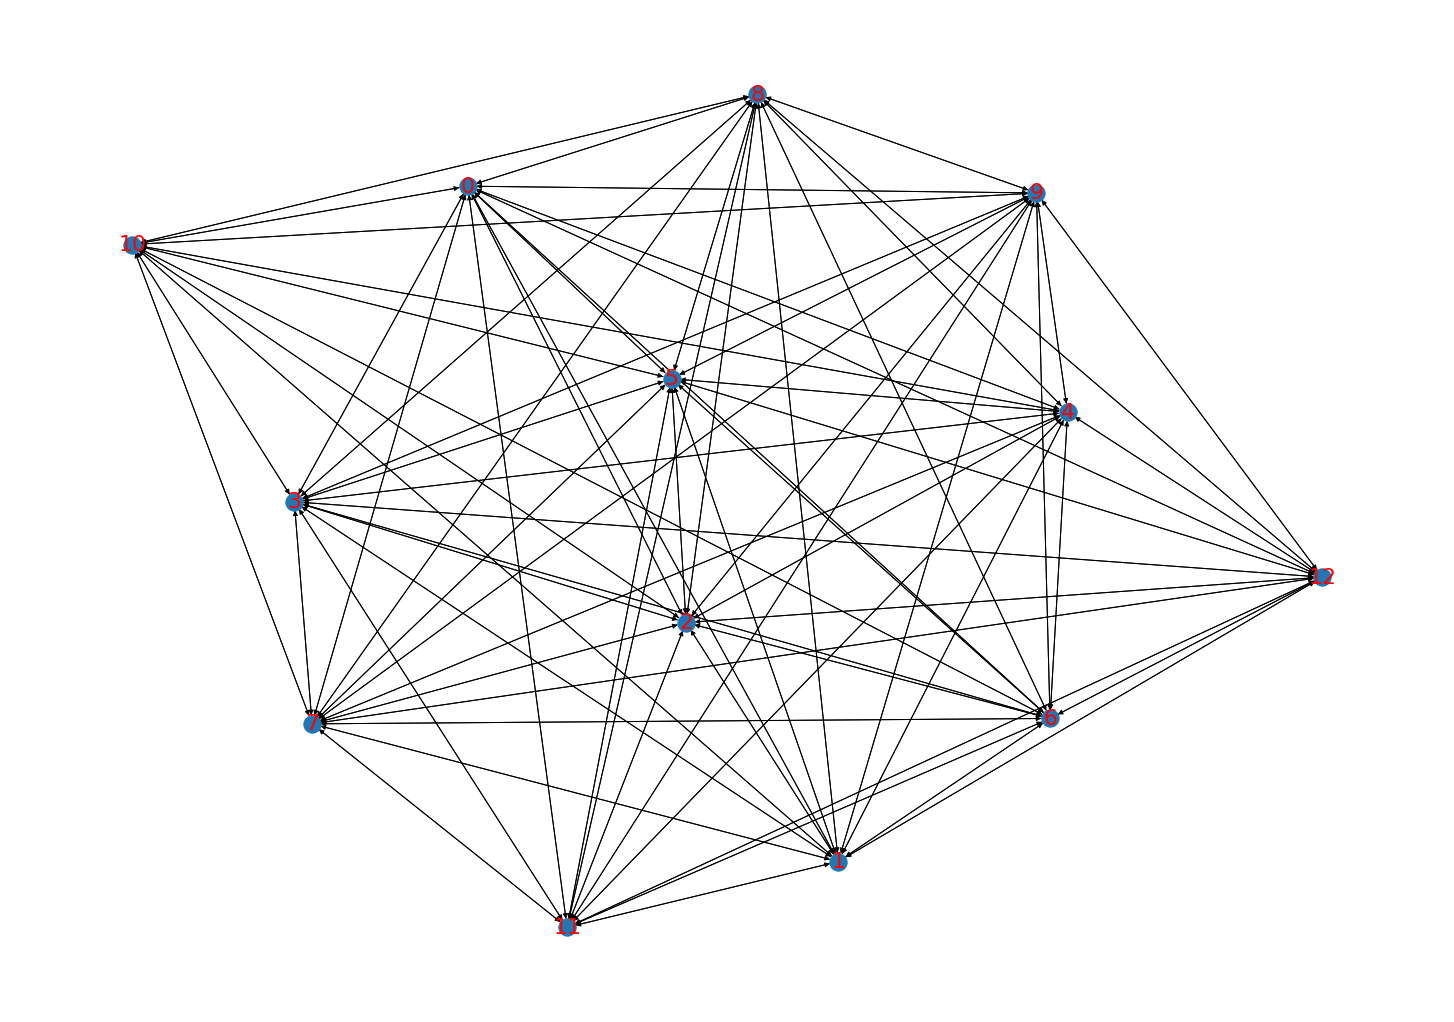

In [12]:
plt.figure(figsize=(20, 14))
nx.draw(DG, with_labels = True, font_size=22, font_color="red")

PageRank (PR) is an algorithm used by Google Search to rank web pages in their search engine results. PageRank is a way of measuring the importance of website pages. According to Google: PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites. (Wikipedia)

In [13]:
pagerank(DG)

{0: 0.07853169195416693,
 1: 0.07853169195416693,
 2: 0.07853169195416693,
 3: 0.07853169195416693,
 4: 0.07853169195416693,
 5: 0.07853169195416693,
 6: 0.07853169195416693,
 7: 0.07853169195416693,
 8: 0.07853169195416693,
 9: 0.07853169195416693,
 10: 0.0681524233217771,
 11: 0.07326532856827686,
 12: 0.07326532856827686}

Hyperlink-Induced Topic Search (HITS; also known as hubs and authorities) is a link analysis algorithm that rates Web pages, developed by Jon Kleinberg. The idea behind Hubs and Authorities stemmed from a particular insight into the creation of web pages when the Internet was originally forming; that is, certain web pages, known as hubs, served as large directories that were not actually authoritative in the information that they held, but were used as compilations of a broad catalog of information that led users direct to other authoritative pages. In other words, a good hub represents a page that pointed to many other pages, while a good authority represents a page that is linked by many different hubs. (Wikipedia)

In [14]:
hits(DG)

({0: 0.0786217359301286,
  1: 0.0786217359301286,
  2: 0.0786217359301286,
  3: 0.0786217359301286,
  4: 0.0786217359301286,
  5: 0.07862173593012858,
  6: 0.07862173593012858,
  7: 0.0786217359301286,
  8: 0.07862173593012858,
  9: 0.07862173593012858,
  10: 0.06708837837613495,
  11: 0.07334713116128953,
  12: 0.07334713116128953},
 {0: 0.0786217359309263,
  1: 0.0786217359309263,
  2: 0.0786217359309263,
  3: 0.0786217359309263,
  4: 0.0786217359309263,
  5: 0.0786217359309263,
  6: 0.0786217359309263,
  7: 0.0786217359309263,
  8: 0.0786217359309263,
  9: 0.0786217359309263,
  10: 0.0670883783782974,
  11: 0.07334713115621978,
  12: 0.07334713115621978})

<b>Weighted walks provided more balanced training and testing scores. Weighted=False created slight underfitting.</b>

In [15]:
G = StellarGraph.from_networkx(G)
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # indicates the walks are weighted
    seed=42  # seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 130


In [16]:
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks)

# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv["12"].shape

(100,)

In [17]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)

In [18]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# the gensim ordering may not match the StellarGraph one, so rearrange
node_targets = G.nodes

In [19]:
len(node_embeddings)

13

In [20]:
node_embeddings[0]

array([-0.17014284,  0.08146069,  0.12688747,  0.1231833 ,  0.0164649 ,
       -0.12648666,  0.13864525,  0.3821194 , -0.2731777 , -0.2974253 ,
        0.10981716, -0.16799372, -0.02265015, -0.09167057,  0.08522005,
       -0.08820198,  0.18943971, -0.05437773, -0.17480513, -0.48278773,
       -0.10315768, -0.01438951,  0.41554353, -0.07321274, -0.0813904 ,
        0.0382259 , -0.17767473,  0.29335922, -0.18136787,  0.16937293,
        0.15273519, -0.12555833,  0.08094447, -0.07852466, -0.11011375,
        0.13009048,  0.07904293,  0.00762443, -0.1107178 ,  0.01826322,
        0.124549  ,  0.03560679, -0.27795726,  0.08567362,  0.06233549,
       -0.13570772,  0.04147609,  0.04509645, -0.02079117,  0.15167554,
        0.08218795, -0.14291301,  0.02546582, -0.09676252, -0.176048  ,
       -0.16687286, -0.10437993, -0.06702099,  0.10329792, -0.027754  ,
       -0.07023417, -0.08024309,  0.42825603, -0.06566346, -0.28019   ,
        0.20458186,  0.05782046,  0.21486855, -0.3664139 , -0.07

In [21]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

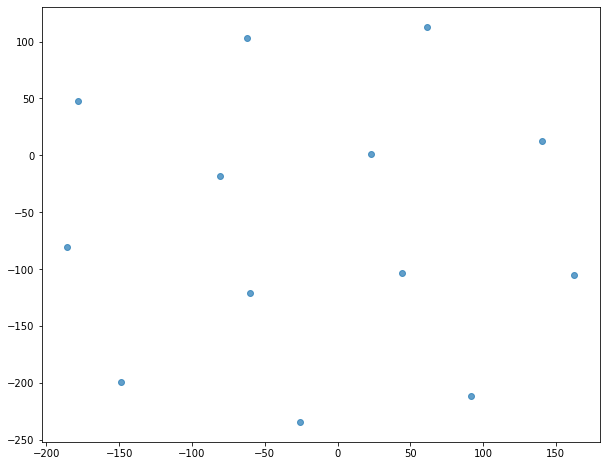

In [22]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    cmap="jet",
    alpha=0.7,
)
plt.show()

In [23]:
cart_sample = training_data[training_data['next_event'] == 'cart']
sample_min = cart_sample.shape[0]

purchase_sample = training_data[training_data['next_event'] == 'purchase'].sample(sample_min)
view_sample = training_data[training_data['next_event'] == 'view'].sample(sample_min)

In [24]:
#now for validation data set
# val_cart_sample = validation_data[validation_data['next_event'] == 'cart']
# val_sample_min = val_cart_sample.shape[0]

# val_purchase_sample = validation_data[validation_data['next_event'] == 'purchase'].sample(val_sample_min)
# val_view_sample = validation_data[validation_data['next_event'] == 'view'].sample(val_sample_min)

In [25]:
cart_sample.shape[0]

6421

In [26]:
model_sample = purchase_sample.append(cart_sample).append(view_sample).reset_index()
# validation_set = val_purchase_sample.append(val_cart_sample).append(val_view_sample).reset_index()

In [27]:
model_sample.shape

(19263, 27)

In [28]:
y = model_sample['next_event']
y_val = validation_data['next_event']

In [29]:
# def sequence_lookback_embedding_concat(embedding_list, sequence, num_lookback):
#     array = np.nan
#     for i in range(1,num_lookback+1):
#         if i == 1:
#             array = embedding_list[sequence[-i]]
#         else:
#             array = np.append(array, embedding_list[sequence[-i]])
#             print(i)
#     return array


# for i in range(len(model_sample)):
#     if i == 0:
#         array = node_embeddings[model_sample.iloc[i]['next_h_lvl']]
#     else:
#         array = np.vstack((array,node_embeddings[model_sample.iloc[i]['next_h_lvl']]))
                          
# X = pd.DataFrame(array)

In [30]:
#Fix try except statement...it breaks when there are num_lookback beyond minimum (3)


def sequence_lookback_embedding_concat(embedding_list, sequence, num_lookback):
    array = np.nan
    for i in range(1,num_lookback+1):
        if i == 1:
            array = embedding_list[sequence[-i]]
        else:
            try:
                array = np.append(array, embedding_list[sequence[-i]])
            except IndexError:
                array = np.append(array, embedding_list[sequence[0]])
    return array

def multi_embedding_df(df, node_embeddings, sequence_col, num_lookback):
    for i in range(len(df)):
        if i == 0:
            array = sequence_lookback_embedding_concat(node_embeddings, df.iloc[0][sequence_col], num_lookback)
        else:
            array = np.vstack((array, sequence_lookback_embedding_concat(node_embeddings, 
                                                                         df.iloc[i][sequence_col], num_lookback)))
    return array

In [31]:
X = multi_embedding_df(model_sample, node_embeddings, 'h_lvl_id_new_labels',7)
X_val = multi_embedding_df(validation_data, node_embeddings, 'h_lvl_id_new_labels',7)  

In [32]:
len(X)

19263

In [34]:
def one_hot_sequence(df, column, num_lookback):
    stacked_listy = []
    for i in range(len(df)):
        one_hot_listy = []
        for j in range(1,num_lookback+1):
            if df.iloc[i][column][-j] == 'view':
                one_hot_listy.append(1)
                one_hot_listy.append(0)
                one_hot_listy.append(0)
            elif df.iloc[i][column][-j] == 'purchase':
                one_hot_listy.append(0)
                one_hot_listy.append(1)
                one_hot_listy.append(0)
            elif df.iloc[i][column][-j] == 'cart':
                one_hot_listy.append(0)
                one_hot_listy.append(0)
                one_hot_listy.append(1)
        stacked_listy.append(one_hot_listy)

    return stacked_listy

In [35]:
X2 = one_hot_sequence(model_sample, 'rml_event_type', 6)
X2_val = one_hot_sequence(validation_data, 'rml_event_type', 6)

In [36]:
X3 = np.append(np.array(X), np.array(X2), axis=1)
X3_val = np.append(np.array(X_val), np.array(X2_val), axis=1)

In [37]:
X3.shape

(19263, 718)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
print(lsvc.score(X_train, y_train))
print(lsvc.score(X_test, y_test))

0.7405580791693706
0.7565533350635868


In [39]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X3)

In [40]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

lsvc_pca = LinearSVC()
lsvc_pca.fit(X_train_pca, y_train_pca)
print(lsvc_pca.score(X_train_pca, y_train_pca))
print(lsvc_pca.score(X_test_pca, y_test_pca))

0.718364698247891
0.7313781468985207


In [41]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
print(gbc.score(X_train, y_train))
print(gbc.score(X_test, y_test))

0.7437378325762491
0.7555151829743058


In [42]:
gbc_pca = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0) \
.fit(X_train_pca, y_train_pca)
print(gbc_pca.score(X_train_pca, y_train_pca))
print(gbc_pca.score(X_test_pca, y_test_pca))

0.745295262816353
0.7500648845055801


In [43]:
#validation set
gbc.score(X3_val, y_val)

0.8306331839053835

In [44]:
X_train.shape

(15410, 718)

In [45]:
X.shape

(19263, 700)

In [46]:
y.head()

0    purchase
1    purchase
2    purchase
3    purchase
4    purchase
Name: next_event, dtype: object

In [83]:
# def map_to_num(col_value):
#     map_dict = {'view':np.array([0,0,1]), 'cart':np.array([0,1,0]), 'purchase':np.array([1,0,0])}
#     return map_dict[col_value]

# model_sample['next_event_num'] = model_sample['next_event'].apply(lambda x: map_to_num(x))
# y_num = model_sample['next_event_num']


def one_hot_sequence2(df, column):
    stacked_listy = []
    for i in range(len(df)):
        one_hot_listy = []
        if df.iloc[i][column] == 'view':
            one_hot_listy.append(1)
            one_hot_listy.append(0)
            one_hot_listy.append(0)
        elif df.iloc[i][column] == 'purchase':
            one_hot_listy.append(0)
            one_hot_listy.append(1)
            one_hot_listy.append(0)
        elif df.iloc[i][column] == 'cart':
            one_hot_listy.append(0)
            one_hot_listy.append(0)
            one_hot_listy.append(1)
        stacked_listy.append(one_hot_listy)

    return stacked_listy

y_nn = pd.DataFrame(one_hot_sequence2(model_sample, 'next_event'))
y_val_nn = pd.DataFrame(one_hot_sequence2(validation_data, 'next_event'))

In [70]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X3, y_nn, test_size=0.2, random_state=42)
X_train_nn = X_train_nn.astype('float32')
X_test_nn = X_test_nn.astype('float32')

# define the keras model
model = Sequential()
model.add(Dense(200, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(3, activation='softmax'))
# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
history = model.fit(X_train_nn, y_train_nn.values, epochs=300, batch_size=60)
# evaluate the keras model
_, accuracy = model.evaluate(X_train_nn, y_train_nn)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/300
257/257 [==============================] - 1s 2ms/step - loss: 0.9671 - accuracy: 0.5068
Epoch 2/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7766 - accuracy: 0.6488
Epoch 3/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7539 - accuracy: 0.6810
Epoch 4/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7521 - accuracy: 0.6806
Epoch 5/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7428 - accuracy: 0.6876
Epoch 6/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7401 - accuracy: 0.6882
Epoch 7/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7429 - accuracy: 0.6944
Epoch 8/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7261 - accuracy: 0.7015
Epoch 9/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7343 - accuracy: 0.6988
Epoch 10/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7217 - accura

257/257 [==============================] - 1s 2ms/step - loss: 0.7096 - accuracy: 0.7222
Epoch 82/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7104 - accuracy: 0.7266
Epoch 83/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7033 - accuracy: 0.7224
Epoch 84/300
257/257 [==============================] - 1s 2ms/step - loss: 0.6980 - accuracy: 0.7208
Epoch 85/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7034 - accuracy: 0.7256
Epoch 86/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7154 - accuracy: 0.7227
Epoch 87/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7011 - accuracy: 0.7225
Epoch 88/300
257/257 [==============================] - 1s 2ms/step - loss: 0.6950 - accuracy: 0.7252
Epoch 89/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7144 - accuracy: 0.7163
Epoch 90/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7186 - accuracy: 

257/257 [==============================] - 1s 2ms/step - loss: 0.7060 - accuracy: 0.7290
Epoch 161/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7177 - accuracy: 0.7171
Epoch 162/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7125 - accuracy: 0.7230
Epoch 163/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7052 - accuracy: 0.7191
Epoch 164/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7093 - accuracy: 0.7217
Epoch 165/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7095 - accuracy: 0.7200
Epoch 166/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7112 - accuracy: 0.7260
Epoch 167/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7103 - accuracy: 0.7218
Epoch 168/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7119 - accuracy: 0.7235
Epoch 169/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7137 - a

257/257 [==============================] - 1s 2ms/step - loss: 0.7001 - accuracy: 0.7171
Epoch 240/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7064 - accuracy: 0.7259
Epoch 241/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7020 - accuracy: 0.7237
Epoch 242/300
257/257 [==============================] - 1s 2ms/step - loss: 0.6967 - accuracy: 0.7255
Epoch 243/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7083 - accuracy: 0.7269
Epoch 244/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7106 - accuracy: 0.7181
Epoch 245/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7116 - accuracy: 0.7167
Epoch 246/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7068 - accuracy: 0.7217
Epoch 247/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7117 - accuracy: 0.7153
Epoch 248/300
257/257 [==============================] - 1s 2ms/step - loss: 0.7200 - a

In [77]:
accuracy

0.7380272746086121

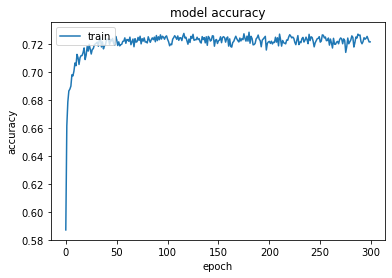

In [71]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

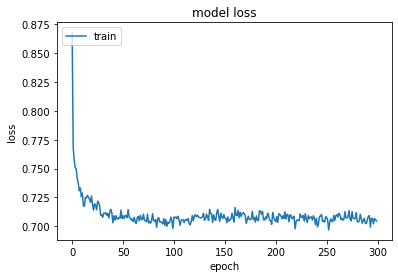

In [73]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X3, y_nn, test_size=0.2, random_state=42)
X_train_nn = X_train_nn.astype('float32')
X_test_nn = X_test_nn.astype('float32')

In [78]:
print(model.evaluate(X_test_nn, y_test_nn))

121/121 [==============================] - 0s 712us/step - loss: 0.6945 - accuracy: 0.7519
[0.6945176720619202, 0.7518816590309143]


In [97]:
print(model.evaluate(X3_val, y_val_nn))

2294/2294 [==============================] - 1s 625us/step - loss: 0.6163 - accuracy: 0.8546
[0.6162667274475098, 0.8546143174171448]


In [ ]:
end = datetime.now()
print(end)
print(end-start)